In [11]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Polinomios Autoregresivos (Modelo ARX)

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas. Usando el modelo ARX:

![OL_LTID2](figuras/lti_arx.png)

Usando el modelo de ecuación de error tenemos que:

$$y[k] = -a_1y[k-1]-...-a_{n_a}y[k-{n_a}] + b_1u[k-1]+b_2u[k-2]+...+b_{n_b}u[k-{n_b}] + e[k]$$

El objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_1, b_2,...,b_{n_b}]^T$. Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[k] = \phi.\theta + e[k]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&u[k-2]&...&u[k-{n_b}]\end{bmatrix}$$

Recordar que del error se pueden introducir los polinomios autoregresivos del modelo ARX:

$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$

$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

Reorganizando entonces:

$$y[k]= \frac{B[z]}{A[z]}u[k] + \frac{1}{A[z]}e[k]$$

$$y[k] = G_e(z)u[k] + H_e(z)e[k]$$

El problema evidente en obtener estas funciones de transferencia estimadas es que se desconoce la naturaleza de la señal $e[k]$, por tanto la señal estimada se debe reconstruir a partir de la función G estimada y el escalón de entrada.

## Ejemplo 1:

Un sistema de segundo orden en tiempo continuo se modela por la siguiente función de transferencia:

$$G(s) = \frac{6}{2s^2+3s+9}$$

En un experimento de laboratorio se obtiene su respuesta al escalo unitario con un sensor obteniendo un conjunto de valores $y_n$

Utilice el modelo ARX para determinar una función de transferencia estimada así:

$$G_e(z) = \frac{B(z)}{A(z)}$$



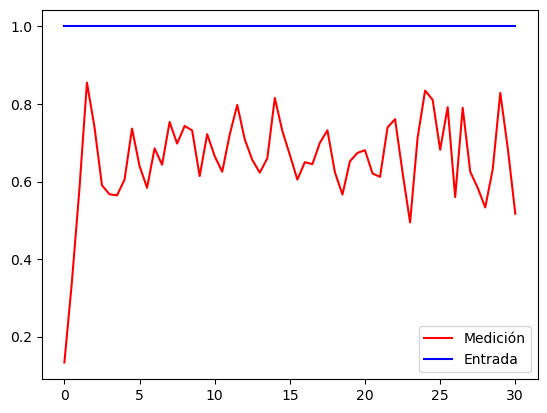

In [12]:
## Sistema de segundo orden en tiempo continuo
g = control.tf([6],[2,3,9])
#g = control.tf([4],[1,10,2])

## Periodo de muestreo y num de muestras para la discretización de la respuesta al escalón
t0 = 0
tf = 30
dt = 0.5
N = int((tf-t0)/dt)+1
t = np.linspace(t0,tf,N)

# Señal de salida ideal "y" y entrada "u"
_,y = control.step_response(g,t)
u = np.ones(N);

## Ruido para simular la señal de salida capturada "yn"
r = 0.08
e = np.random.normal(0,r,size=N)

yn = y+e
plt.plot(t,yn,color = 'red')
plt.plot(t,u,color = 'blue')
plt.legend(['Medición','Entrada'])

## Definir la matriz de regresión

Para estimar el modelo se debe usar la matriz de regresión lineal, involucrando estados anteriores de la salida y de la entrada.
$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&u[k-2]&...&u[k-{n_b}]\end{bmatrix}$$

In [13]:
## Definir y_1, y_2, y_3, dependiendo el sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
    
## Creación del vector phi
phi = np.array([-y_1,-y_2,u_1,u_2]).transpose()
##phi = np.array([-y_1,-y_2,u_1]).transpose()

array([[-0.        , -0.        ,  0.        ,  0.        ],
       [-0.13326339, -0.        ,  1.        ,  0.        ],
       [-0.34148409, -0.13326339,  1.        ,  1.        ],
       [-0.5810171 , -0.34148409,  1.        ,  1.        ],
       [-0.8551527 , -0.5810171 ,  1.        ,  1.        ],
       [-0.74067456, -0.8551527 ,  1.        ,  1.        ],
       [-0.59030409, -0.74067456,  1.        ,  1.        ],
       [-0.56714943, -0.59030409,  1.        ,  1.        ],
       [-0.56430387, -0.56714943,  1.        ,  1.        ],
       [-0.60464519, -0.56430387,  1.        ,  1.        ],
       [-0.73664429, -0.60464519,  1.        ,  1.        ],
       [-0.63997821, -0.73664429,  1.        ,  1.        ],
       [-0.5838133 , -0.63997821,  1.        ,  1.        ],
       [-0.6855579 , -0.5838133 ,  1.        ,  1.        ],
       [-0.64338236, -0.6855579 ,  1.        ,  1.        ],
       [-0.75360365, -0.64338236,  1.        ,  1.        ],
       [-0.69788581, -0.

## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$

La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad. Existirán tantos parámetros como columnas tenga la matriz de regresión.

In [14]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.

alpha = 0
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.29993541,  0.2539257 ,  0.30151368,  0.33810583])

## Determinando los polinomios autoregresivos
$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$
$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

In [15]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
B = theta[2]*z**-1 + theta[3]*z**-2 

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()

H = 1/A
H = H.simplify()

print(G)
print(H)

(0.301513679975585*z + 0.338105830935845)/(z**2 - 0.299935406013891*z + 0.253925699680867)
z**2/(z**2 - 0.299935406013891*z + 0.253925699680867)


## Construir la función estimada en tiempo discreto
$$G_e(z)=\frac{B(z)}{A(z)} = \frac{b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-n_b}}{1+a_1z^{-1}+...+a_{n_a}z^{-n_a}}$$

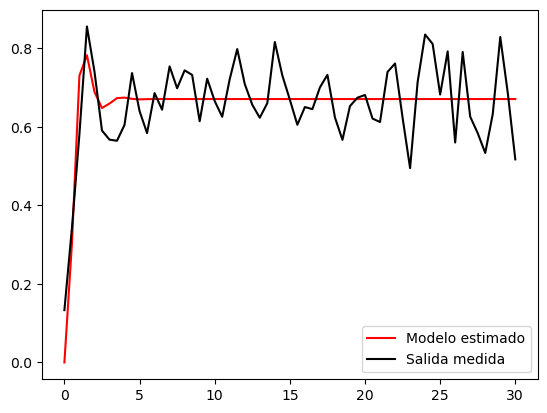

In [16]:
## Se crea el sistema estimado
G_e = control.tf([theta[2],theta[3]],[1,theta[0],theta[1]],dt)

## Se determina la respuesta estimada al escalón
_,ye = control.step_response(G_e,t)
plt.plot(t,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo estimado','Salida medida'])
#plt.xlim([0, t[len(t)-1]])   

ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)

In [17]:
## Función de transferencia G(z)
print(G_e)
print(ECM)


   0.3015 z + 0.3381
-----------------------
z^2 - 0.2999 z + 0.2539

dt = 0.5

0.010468739028476795


In [18]:
## Discretizando el sistema original para comparar funciones

gd = control.c2d(g,dt)
print(gd)



   0.2711 z + 0.2093
-----------------------
z^2 - 0.7517 z + 0.4724

dt = 0.5



(array([0.1499677+0.48107732j, 0.1499677-0.48107732j]),
 array([-1.12136149+0.j]))

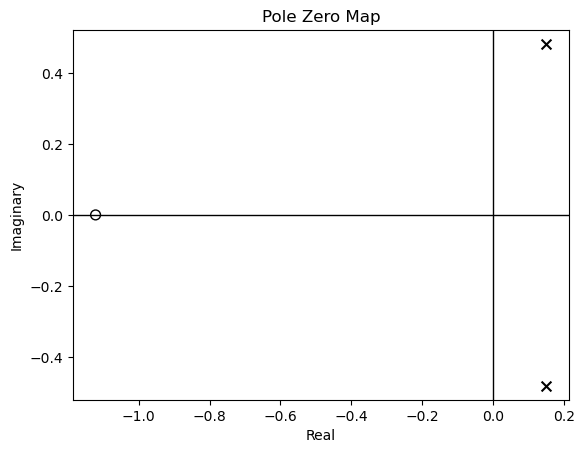

In [19]:
control.pzmap(G_e)

(array([0.37586854+0.57540368j, 0.37586854-0.57540368j]),
 array([-0.77211532+0.j]))

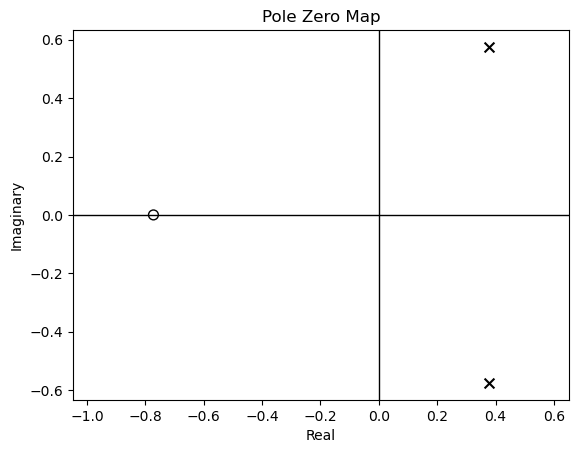

In [10]:
control.pzmap(gd)